# Notebook for sampling high error structures obtained through adaptive sampling using k-means clustering for gas-surface dynamics, on the example of H<sub>2</sub>/Cu(111).

In [52]:
import matplotlib
import matplotlib.pyplot as plt
from ase.io import write, read
import numpy as np

fig = plt.figure()
SMALL_SIZE = 14
MEDIUM_SIZE = 14
BIGGER_SIZE = 14

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

line_width = 0.8
matplotlib.rcParams['axes.linewidth'] = line_width
matplotlib.rcParams['font.sans-serif'] = "Arial"
matplotlib.rcParams['lines.markeredgewidth'] = 0.5
matplotlib.rcParams['lines.linewidth'] = 0.8

<Figure size 640x480 with 0 Axes>

### Load all high-error structures

In [53]:
db_p = 'output_h2cu111_example.db'
db_out_p = 'h2cu_clust_centr.xyz' # Path for saving cluster centres
ncluster = 80 # Number of clusters (final structures that will be added to our database)

# Read all high error structures
struct_all = read(f'{db_p}@:')
print(len(struct_all))

69738


In [54]:
struct_all[10].get_atomic_numbers()

array([29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29,
       29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29,
       29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29,
       29, 29, 29,  1,  1])

### Get distances for each structure

In [55]:
dist_all = []
H2_dist = np.zeros((len(struct_all),3))
# For H2 get the minimum distance to all atoms
for j in range(len(struct_all)):
    dist_cur = struct_all[j].get_all_distances(mic=True)
    # Save dist_all list for inverse distance matrix later
    dist_all.append(dist_cur)
    # Minimal descriptor
    H2_dist[j][0] = dist_cur[-1,-2] # Distance between H-H
    H2_dist[j][1] = np.min(dist_cur[-1,:-2]) # Min distance between H1-Cu
    H2_dist[j][2] = np.min(dist_cur[-2,:-2]) # Min distance between H2-Cu


### Get inverse distance matrix
We chose to use inverse distances, as we think this is enough for our use case, but you can also use other descriptors, like Coulomb matrix, SOAP, etc. 

In [56]:
natoms = len(struct_all[0].get_all_distances())
invd = np.zeros((len(dist_all),natoms,natoms))

# Make 1s out of the diagonal
for i in range(len(dist_all)):
    np.fill_diagonal(dist_all[i],1.0)
    invd[i] = np.ones((natoms,natoms))/dist_all[i]

# We will use invd[:,-2:], which refers to the inverse distances between both H atoms and all atoms
invd_reduced = invd[:,-2:]

#### Reshaping for following calculations

In [57]:

invd = invd.reshape(len(dist_all),natoms*natoms)
invd_reduced = invd_reduced.reshape(len(dist_all),-1)
print(invd.shape,invd_reduced.shape)

(69738, 3136) (69738, 112)


# K-Means clustering

### Geometry-based clustering: 

We will use "invd_reduced" (inverse distance matrix) as a descriptor.

In [58]:
descr = invd_reduced

#### Use PCA to check if we can either reduce the descriptor to lower dimension or to check if the descriptor is good:

[0.53031428 0.17587801 0.04588687 0.04349948 0.04192744 0.04153486
 0.03868688 0.03516604 0.00884738 0.00639733]
[99.62926468 57.37544075 29.30653548 28.53397571 28.01363416 27.88217308
 26.90928216 25.65558858 12.86849073 10.94258116]


<BarContainer object of 10 artists>

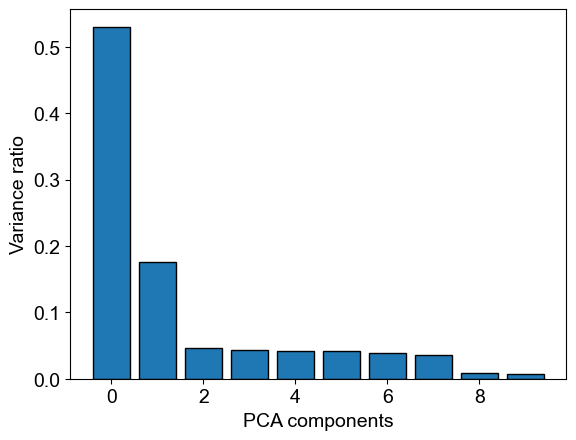

In [59]:
from sklearn.decomposition import PCA

pca = PCA(n_components=10)
pca.fit(descr)
print(pca.explained_variance_ratio_)
print(pca.singular_values_)
X_new = pca.transform(descr)

plt.xlabel("PCA components")
plt.ylabel("Variance ratio")

plt.bar(np.arange(10),pca.explained_variance_ratio_, edgecolor='black')

First two components cover most of the variance in the data, which is why we'll use these.

In [60]:
print(X_new.shape)
descr = X_new[:,:2]
print(descr.shape)

(69738, 10)
(69738, 2)


### Plot our structures within the obtained principal components: PC1 and PC2

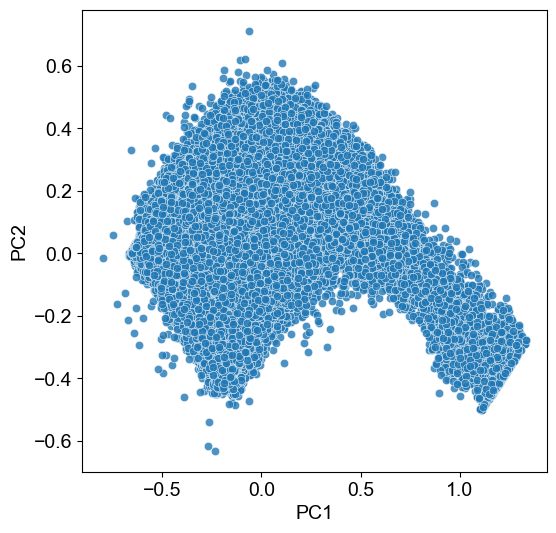

In [61]:
fig, ax = plt.subplots(1, 1)

ax.scatter(descr[:,0], descr[:,1], edgecolors='white', linewidths=0.4, label="datapoints", alpha=0.8)

plt.xlabel("PC1")
plt.ylabel("PC2")
fig.set_figheight(6.0)
fig.set_figwidth(6.0)

plt.show()

# Clustering 

In [62]:
from sklearn.cluster import MiniBatchKMeans

niter = 1000000
minibatch = 1800 # Batch size (how many data points are treated in the algorithm at once, reduce if you run out of memory)
kmeans = MiniBatchKMeans(n_clusters=ncluster,
                        init="k-means++",
                        max_iter=niter,
                        batch_size=minibatch)
# Fit the clustering model
km = kmeans.fit(np.array(descr).reshape(-1,1))
# Use the clustering model to predict the cluster number of each data point
indices = km.fit_predict(descr)

/Users/wojciechstark/miniconda3/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 3 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/Users/wojciechstark/miniconda3/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 3 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


## Centers of the clusters

We will compute the center of each cluster and find the structure that is closest to the minimum of each cluster.

The indices will specify the index of the struct_all array.

In [63]:
from sklearn.metrics.pairwise import pairwise_distances_argmin

centroid = kmeans.cluster_centers_
b = np.inf
ind = pairwise_distances_argmin(centroid, descr)
print(ind)

geometries = []
X_centers = []
H2_centers = []

for i in range(len(ind)):
    geometries.append(struct_all[ind[i]])
    X_centers.append(X_new[ind[i]])
    H2_centers.append(H2_dist[ind[i]])

# Save the chosen center structures
write(db_out_p, geometries)

H2_centers = np.array(H2_centers)
X_centers = np.array(X_centers)

[13547   325 37879  8578 43883 65655 69281 55284  1291 10185 32903 56405
 58441 55411  9141 21029 17838 34677 59348 69146 13762 31315 61454 27338
   953 36974  9126 57037  6191 29050 10761 22031 58963  5096 46051 26753
 28860 59716  4639 12368 60571  5520  3482 58701 40254 20957 18230 56283
 64688 52790 28040 30758 17455 15955 44074  3143 47792  4374 55369  5493
 43668 55385 38960 26080 61264 65940  3111 65987 49889 10266 64330 40049
 25534  1392 55862 48920  2842 68146 14008 57871]


## Plotting clusters within PCs

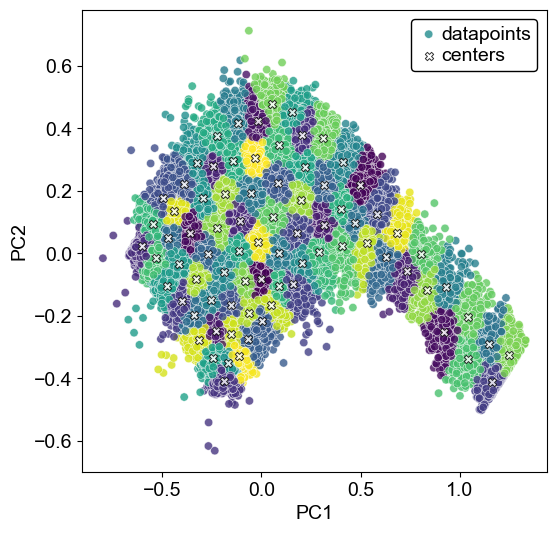

In [64]:
fig, ax = plt.subplots(1, 1)

ax.scatter(X_new[:,0], X_new[:,1],c=indices, edgecolors='white', linewidths=0.4, label="datapoints", alpha=0.8)
ax.scatter(X_centers[:,0],X_centers[:,1],color="white",label="centers",edgecolors='black',linewidths=0.7,marker="X", alpha=0.8)

plt.legend(fancybox=True,framealpha=1,edgecolor='black',handletextpad=0.05,borderpad=0.3,handlelength=1.2,columnspacing=0.4,labelspacing=0.2,ncol=1,loc=1, fontsize="medium") #, bbox_to_anchor=(1.75, 1.02))
plt.xlabel("PC1")
plt.ylabel("PC2")
fig.set_figheight(6.0)
fig.set_figwidth(6.0)

plt.show()

###  Plot the same within H-H distance and H1-Cu distance

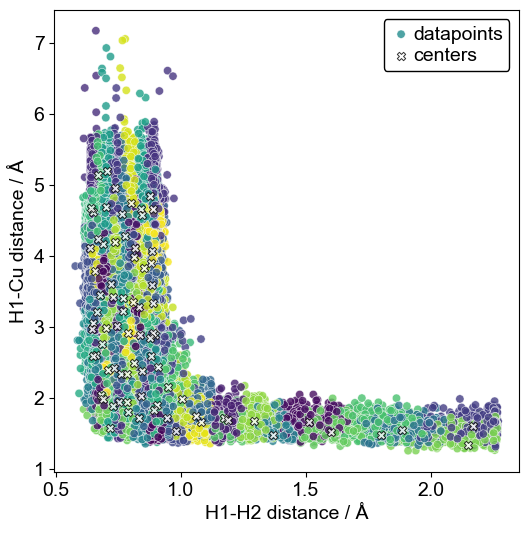

In [65]:
fig, ax = plt.subplots(1, 1)

ax.scatter(H2_dist[:,0], H2_dist[:,1],c=indices,edgecolors='white', linewidths=0.4, label="datapoints", alpha=0.8)
ax.scatter(H2_centers[:,0],H2_centers[:,1],color="white",label="centers",edgecolors='black',linewidths=0.7,marker="X", alpha=0.8)

plt.legend(fancybox=True,framealpha=1,edgecolor='black',handletextpad=0.05,borderpad=0.3,handlelength=1.2,columnspacing=0.4,labelspacing=0.2,ncol=1,loc=1, fontsize="medium") #, bbox_to_anchor=(1.75, 1.02))
plt.xlabel("H1-H2 distance / Å")
plt.ylabel("H1-Cu distance / Å")
fig.set_figheight(6.0)
fig.set_figwidth(6.0)

plt.show()

#### Additional plot to see how diverse PC1 we are getting in the end

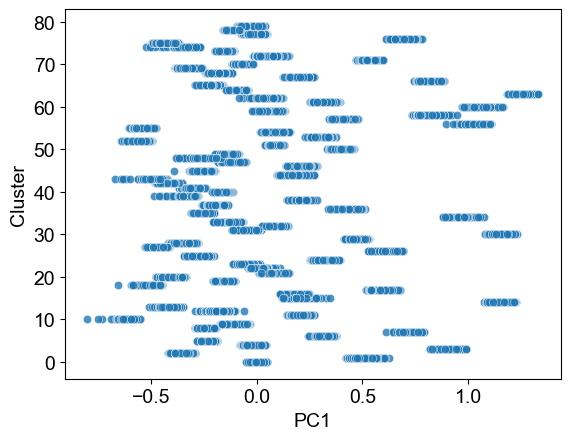

In [66]:
ax = plt.axes()

ax.scatter(X_new[:,0], indices, edgecolors='white', linewidths=0.4, alpha=0.8)

plt.xlabel("PC1")
plt.ylabel("Cluster")

plt.show()

# 